In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os, sys

import numpy as np
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

from keras.layers import Input, Dense, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

import string
import pandas as pd
import re
import nltk

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


INITIALIZATION

In [2]:
# list of texts to be classified
texts = [] 
# list of label ids
labels = []   
# dictionary mapping label index to label name
labels_Index = {}  

In [3]:
#List data sources paths
PATH=os.getcwd()
os.listdir(PATH)
os.listdir('../')

['input', 'working', 'config', 'lib']

PREPROCESSING

In [4]:
def clean_text(text):
    """
    To Clean each text message with any non-textual content.
    """
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()

    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

In [5]:
data_df = pd.read_csv("../input/labdatacsv/train.csv", sep=',')
data_df.converse = data_df.converse.astype(str)
#data_df.head(1)

#Check NA values
data_df.isna().any()
data_df.dropna(inplace=True) # We will drop the NA records.\n",
data_df.isna().any()
data_df['converse'] = data_df['converse'].map(lambda x: clean_text(x))

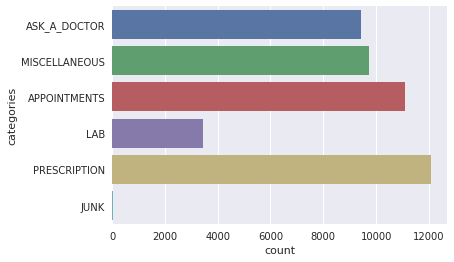

In [8]:
#Check the Class distribution
import seaborn as sb
sb.set(style="darkgrid")

ax = sb.countplot(y=data_df['categories'])

In [11]:
# INIT
data_df['categories'] = data_df['categories'].astype('category')
data_df['labels'] = data_df['categories'].cat.codes
labels_Index = dict( enumerate(data_df['categories'].cat.categories) )
labels = data_df['labels'].tolist()
texts = data_df['converse'].astype(str).tolist()

print("labels  %d" %len(labels))
print ("Text Classes: {}".format(labels_Index))
print ("Text samples found are %d" %len(texts))

labels  45825
Text Classes: {0: 'APPOINTMENTS', 1: 'ASK_A_DOCTOR', 2: 'JUNK', 3: 'LAB', 4: 'MISCELLANEOUS', 5: 'PRESCRIPTION'}
Text samples found are 45825


In [12]:
# Prepare tokenizer and create unique tokens from the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_Index = tokenizer.word_index
vocab_size = len(word_Index) + 1
print('Found %s unique tokens.' % vocab_size)

Found 34770 unique tokens.


In [13]:
# integer encode the documents
sequences = tokenizer.texts_to_sequences(texts)
print(texts[1], sequences[1]) #Debug

for i in sequences:
    print (len(i))


patients to discuss drugname she says she has a weird tas patient prescription other prescription comments patients to discuss drugname she says she has a weird taste in her mouth and patients also sweats heavily please to discuss rna follow patients states her food has no favor in last week started drugname mg and she is having problem with excessive sweating and pain is unrelieved please advise next steep mary morton lpn rna follow ok to stop md [2, 1, 121, 14, 6, 127, 6, 37, 11, 3157, 12715, 8, 60, 38, 60, 299, 2, 1, 121, 14, 6, 127, 6, 37, 11, 3157, 3964, 17, 19, 695, 3, 2, 141, 6937, 7363, 20, 1, 121, 22, 26, 2, 61, 19, 1234, 37, 97, 6614, 17, 88, 164, 330, 14, 12, 3, 6, 10, 159, 679, 16, 2081, 3421, 3, 87, 10, 8547, 20, 67, 158, 10697, 170, 325, 110, 22, 26, 149, 1, 477, 44]
108
78
177
153
74
33
3
5
33
47
22
108
20
34
110
7
118
6
53
131
21
41
40
109
140
7
105
105
99
128
18
176
7
81
185
87
55
35
131
102
59
160
31
25
55
184
147
27
37
75
120
55
105
56
39
115
156
189
59
24
44
7
78
8


48
16
10
56
19
125
45
131
46
60
10
116
144
135
36
9
91
120
72
142
120
8
141
41
39
88
52
12
37
110
41
47
29
202
7
168
160
108
116
79
136
50
129
32
38
146
166
131
57
9
23
116
119
111
8
125
63
163
187
29
155
34
91
54
163
6
7
147
160
238
111
15
97
83
126
165
119
78
22
47
39
154
158
99
57
141
152
128
32
22
43
110
77
96
83
57
92
18
122
20
161
140
142
54
16
99
8
6
56
151
7
7
69
85
101
133
105
171
94
77
119
110
73
13
25
8
10
35
110
211
1
114
42
64
42
54
49
95
36
17
81
17
52
128
40
121
130
100
125
90
105
19
15
171
34
171
56
184
94
151
22
125
109
185
24
168
20
190
87
50
156
95
61
98
43
59
101
27
5
93
161
47
104
145
22
3
44
47
184
197
40
111
92
98
61
55
152
93
7
20
158
91
111
96
128
60
143
105
119
75
150
148
105
31
128
37
72
87
120
157
8
44
35
93
46
14
69
105
58
145
104
36
149
54
210
107
50
122
214
36
6
101
146
227
96
100
20
132
77
75
87
43
35
217
75
104
124
111
47
228
83
190
4
39
73
138
113
85
93
177
113
113
133
48
30
122
146
99
39
34
98
23
93
84
27
112
139
93
154
139
115
123
4
47
55
29
29
86
76

129
56
153
70
64
13
13
14
51
3
10
27
58
3
17
19
58
110
89
8
25
58
53
8
8
10
74
29
61
10
25
6
6
33
5
66
6
6
6
91
18
8
14
65
45
110
3
4
23
28
4
18
61
13
3
65
83
187
28
4
13
10
10
25
6
4
66
61
99
39
29
22
93
7
6
11
42
88
21
21
3
119
74
16
11
10
22
87
11
4
27
4
36
3
5
64
92
54
41
12
41
21
3
5
5
29
54
16
5
71
15
91
3
56
82
33
68
8
105
53
28
76
51
54
162
135
122
57
123
22
106
16
23
109
72
91
100
72
135
134
99
58
80
126
62
62
113
195
81
201
121
20
79
167
5
5
31
74
9
152
69
146
61
162
166
42
127
117
157
114
85
131
106
95
51
150
41
91
69
16
130
21
22
130
111
37
33
110
36
143
40
165
67
22
58
119
44
90
25
122
43
52
7
125
92
90
87
84
139
144
105
116
143
109
88
61
119
162
105
104
34
27
30
41
7
149
183
130
182
122
19
17
171
85
9
57
70
140
62
120
127
136
197
116
159
138
131
25
46
37
14
97
77
7
38
186
13
180
131
47
162
147
74
107
125
223
71
143
27
8
101
131
69
91
77
15
37
11
132
136
165
136
150
19
42
57
46
9
7
4
4
65
16
54
28
220
19
29
22
182
212
115
36
168
88
22
115
3
8
119
60
167
64
162
87
8
13
93
1

52
124
17
27
71
93
19
41
36
3
95
42
23
151
141
176
97
59
27
124
47
168
156
126
48
59
38
93
65
24
121
76
112
189
101
140
21
5
36
13
54
194
89
19
7
33
75
69
144
162
48
55
78
150
73
32
45
42
32
90
42
126
17
100
99
72
56
62
41
206
46
138
24
104
55
139
55
119
10
101
100
33
117
24
118
126
228
192
123
55
47
17
179
107
66
108
163
174
65
37
38
14
33
130
50
146
37
111
52
28
15
136
9
39
142
124
130
152
142
103
153
80
100
87
7
144
30
47
42
49
74
201
70
50
80
44
16
54
84
169
45
54
16
153
166
161
63
95
41
44
56
51
225
213
62
77
19
113
132
73
158
46
151
66
10
60
122
98
7
40
82
35
143
11
58
82
87
27
12
23
107
170
132
59
121
68
112
41
15
152
98
65
49
27
20
32
128
7
9
97
62
87
133
16
96
146
96
142
18
32
105
51
41
6
38
16
14
67
58
16
172
52
114
25
125
172
65
77
39
33
4
121
48
29
36
132
7
121
19
64
52
111
22
30
16
176
183
101
184
32
175
118
166
123
72
85
64
66
5
129
89
46
29
58
78
56
28
153
109
69
106
139
58
5
148
159
9
6
142
113
45
154
19
23
26
43
38
77
18
69
67
165
8
54
85
21
69
86
158
128
142
26
85
37


102
108
51
104
88
132
153
56
85
34
185
124
25
102
78
229
106
62
34
47
101
24
79
124
34
83
75
79
154
80
44
148
27
151
53
89
45
66
131
148
94
46
50
114
162
94
123
68
168
82
83
118
167
141
53
50
76
31
98
52
27
85
43
105
36
28
147
149
155
36
22
45
45
60
5
5
41
47
29
61
101
15
141
70
137
54
158
25
32
81
63
16
104
56
77
37
38
90
3
3
150
4
55
212
26
41
51
87
33
53
31
25
26
83
43
12
169
51
77
20
39
19
29
45
24
57
173
138
40
53
31
48
121
124
53
27
25
101
72
105
61
33
74
112
69
33
84
185
43
130
65
40
89
124
158
89
176
41
5
155
7
55
17
48
110
154
213
158
88
153
4
28
77
69
78
94
160
102
41
132
28
108
179
78
89
9
35
130
49
142
9
85
65
24
34
154
70
53
8
160
16
170
101
136
154
211
115
169
73
49
41
4
101
213
43
56
171
46
69
131
75
151
5
177
81
23
84
64
95
66
61
92
89
155
154
137
63
96
34
68
168
60
80
52
113
69
172
132
14
36
47
83
88
31
73
258
146
71
95
21
71
58
197
4
167
143
45
91
75
93
20
4
37
128
125
93
48
120
107
84
25
149
64
3
22
42
66
37
118
14
112
100
40
62
252
45
24
68
160
74
29
5
4
8
85
39
23


6
43
140
47
199
58
50
196
79
163
148
146
103
111
98
177
15
48
53
35
189
111
171
199
124
94
162
100
36
13
101
139
147
23
40
132
114
99
130
125
137
175
165
265
130
55
93
55
61
213
105
138
136
56
86
86
98
131
88
85
140
55
37
152
23
33
93
35
17
26
98
69
39
40
164
150
109
34
98
138
30
6
186
63
91
78
112
129
100
93
154
53
70
15
91
100
87
306
49
50
45
118
92
53
25
39
64
95
119
24
60
144
171
131
166
173
86
42
126
160
155
49
64
84
99
132
69
97
171
23
121
45
14
197
63
27
97
46
59
157
100
95
85
52
51
103
21
26
181
40
51
208
46
103
119
30
36
144
64
26
209
206
17
54
71
51
80
57
167
70
114
26
150
54
50
94
62
61
140
202
45
96
51
74
22
19
68
55
62
74
33
9
83
50
75
45
149
109
210
209
76
138
32
142
198
73
45
33
24
4
106
105
44
9
118
25
111
52
108
54
51
100
65
16
128
25
97
144
20
57
4
153
26
145
66
122
108
22
29
43
16
74
136
143
121
215
95
5
160
132
38
95
162
64
91
62
26
24
42
22
53
40
180
36
51
24
26
40
62
37
194
186
70
46
174
57
4
72
7
44
34
40
76
36
14
50
10
29
14
99
102
75
46
24
30
44
61
46
84
32
99


100
50
70
194
57
38
36
39
41
129
96
7
136
123
31
10
83
22
87
102
212
69
130
84
81
142
111
115
79
100
158
53
133
55
144
159
184
89
63
65
14
121
181
32
68
87
71
64
160
83
63
79
60
78
107
185
38
136
54
43
46
26
140
45
75
116
153
29
51
62
99
49
217
98
100
161
87
67
64
45
92
21
38
159
25
144
137
49
37
78
177
75
28
145
101
58
39
20
27
79
83
186
55
103
119
107
57
13
73
190
4
34
76
130
48
184
63
49
52
78
60
99
55
17
33
46
27
53
29
95
37
54
126
34
191
42
206
18
119
24
146
75
140
69
99
49
31
104
28
86
107
101
97
73
101
29
40
47
179
175
162
53
155
160
46
89
65
195
115
14
79
88
103
57
66
214
175
6
90
16
147
27
136
99
107
116
46
31
193
76
133
107
228
99
156
99
152
48
142
168
34
59
157
130
213
76
102
160
27
16
165
20
143
58
89
55
8
141
76
31
203
125
126
43
189
178
171
17
122
70
94
49
159
74
100
30
150
130
76
205
138
10
20
132
33
180
97
93
127
17
15
4
56
43
19
119
23
100
89
64
76
101
34
94
54
133
80
48
115
20
8
80
5
26
88
185
116
82
81
187
63
89
1
56
134
137
72
98
127
150
54
123
118
75
25
101
26
49
7

176
159
76
208
94
112
51
13
22
46
24
91
22
14
82
34
22
164
100
42
110
95
54
116
53
149
138
34
117
133
100
116
38
145
82
82
106
74
34
77
27
58
114
158
26
36
105
27
144
62
124
56
129
135
48
73
7
67
91
166
30
148
56
59
164
10
58
47
101
174
142
46
18
5
99
91
89
37
7
131
87
180
79
111
38
8
40
108
7
166
26
4
27
79
77
23
135
184
83
179
33
89
127
51
83
95
79
146
80
110
83
28
36
34
158
22
74
34
90
40
51
34
41
50
51
205
76
61
197
17
122
55
209
45
80
130
149
45
60
23
183
200
167
117
2
90
98
26
149
90
9
139
88
114
144
56
58
22
37
78
72
138
88
82
52
29
97
37
5
24
80
202
21
8
27
196
22
100
89
150
3
9
111
95
93
55
79
14
58
10
147
74
101
147
33
22
93
105
35
58
79
35
85
66
182
110
21
185
66
56
99
93
45
79
26
56
143
140
149
18
91
174
92
18
63
155
63
75
96
84
73
84
55
74
50
88
121
65
7
63
22
39
154
214
105
96
24
133
143
18
192
16
94
82
166
32
49
35
20
30
115
17
26
59
130
83
120
36
85
51
15
116
110
76
17
23
44
15
23
65
101
84
82
206
115
26
136
58
103
85
32
148
114
52
6
95
41
35
27
10
57
81
81
202
27
30
17

72
41
76
68
34
50
74
26
152
86
120
22
179
75
75
66
167
113
127
119
128
82
170
11
113
32
61
60
25
64
107
128
209
55
40
16
70
26
184
59
23
91
42
68
44
178
68
26
24
17
241
197
133
141
242
132
196
83
137
28
180
47
58
66
45
56
37
12
112
116
150
128
74
183
118
58
145
153
43
209
168
22
114
61
72
92
115
67
53
43
53
53
138
163
55
75
53
53
74
35
64
40
33
114
76
143
49
61
180
10
43
27
159
116
136
52
105
112
183
62
38
36
77
102
53
54
199
19
19
9
37
112
146
124
79
56
25
8
133
173
80
98
54
165
57
62
129
64
195
93
72
8
54
166
30
23
59
137
22
63
34
90
57
158
25
167
34
181
30
18
10
146
160
49
157
35
55
82
56
182
129
138
37
85
7
47
85
17
4
21
29
99
90
213
75
67
39
44
100
149
140
8
24
20
81
50
112
167
27
45
161
85
52
97
49
89
192
82
1
64
110
171
81
52
65
33
58
36
132
33
38
99
134
26
89
103
107
22
115
189
35
53
135
32
125
94
34
137
81
95
19
161
42
70
100
47
70
155
44
28
238
156
199
139
15
108
86
90
29
76
69
81
140
30
62
7
147
197
7
75
168
153
37
94
31
59
108
96
81
64
38
46
148
140
4
171
158
153
169
133
70

80
142
12
37
30
164
178
184
82
7
59
120
16
14
13
12
10
45
10
4
6
6
16
77
51
44
19
93
127
53
12
57
19
186
8
17
29
6
188
90
57
161
32
36
14
7
119
95
52
33
33
136
100
105
7
145
31
66
65
10
121
45
18
3
30
13
11
6
6
115
4
9
8
24
52
27
23
175
65
57
18
135
45
25
58
42
11
27
64
32
4
38
106
114
103
7
29
65
65
51
64
55
51
50
41
20
107
70
6
124
159
29
19
9
83
7
74
7
69
140
15
117
101
71
3
140
69
50
20
19
115
123
155
78
30
56
14
3
114
7
5
111
20
19
39
4
15
19
10
8
8
2
37
107
196
47
54
87
2
47
71
99
14
63
18
97
94
92
57
37
61
16
42
39
112
35
6
21
27
6
11
88
66
11
15
3
115
72
24
10
15
17
133
19
3
178
36
21
3
5
16
57
8
12
93
19
39
21
41
79
95
38
39
165
41
19
36
17
38
9
16
107
87
5
25
14
75
41
104
21
22
4
64
10
118
52
6
64
24
39
12
168
26
72
170
8
66
192
100
100
39
3
16
29
192
59
6
5
6
55
94
16
17
7
46
44
55
161
13
74
9
63
7
103
6
9
17
76
48
19
14
11
69
80
5
14
35
9
87
249
56
74
6
6
14
5
6
43
14
17
151
45
40
48
30
78
23
16
96
6
6
10
102
18
12
12
50
45
21
7
7
22
78
21
16
14
6
4
71
21
23
28
92
72
46
144

78
89
55
137
111
149
64
94
134
76
67
119
22
65
69
61
43
44
66
72
126
41
9
171
128
22
42
31
36
157
41
126
12
52
63
51
21
105
97
116
65
22
110
86
159
122
95
88
120
52
93
177
69
61
39
240
67
9
42
98
30
135
9
65
154
32
36
232
111
56
235
90
71
147
73
47
110
25
161
8
159
137
136
86
165
85
41
96
85
48
236
51
140
166
12
66
100
28
18
39
135
137
118
153
114
184
74
87
14
89
92
182
47
66
24
47
120
50
173
10
204
145
26
143
86
63
163
67
141
105
20
176
115
96
103
36
43
49
104
68
155
99
149
66
104
70
34
93
151
65
207
53
107
91
50
55
94
201
136
108
55
146
37
44
15
11
49
4
69
130
7
37
137
41
65
86
45
90
93
23
199
42
100
142
22
50
79
130
64
80
49
18
192
81
81
80
112
165
75
42
13
119
103
45
59
34
93
76
61
165
177
125
153
90
141
37
153
59
4
110
35
99
137
75
115
100
40
92
51
194
128
45
65
117
49
62
85
70
90
5
77
123
38
12
54
33
100
103
11
61
135
54
162
83
169
44
106
35
38
25
28
4
81
75
160
117
98
70
76
44
101
82
124
3
14
45
36
101
58
19
136
55
95
126
75
33
27
57
60
32
74
56
139
118
28
89
24
3
8
128
47
38
24

9
61
197
208
41
33
51
68
159
118
40
74
38
154
6
158
9
5
135
91
97
132
57
49
84
141
111
126
93
123
57
31
153
142
213
39
76
188
41
41
63
68
34
149
38
29
42
117
66
9
2
108
104
111
46
32
34
31
44
152
46
100
14
183
45
15
57
96
30
75
145
206
33
136
107
34
16
67
154
108
90
78
21
116
112
73
141
130
36
90
19
81
58
82
48
182
69
99
39
26
5
79
43
33
46
46
84
76
114
73
84
119
118
44
233
95
35
39
37
14
149
135
91
4
86
129
95
50
84
186
36
152
151
67
78
65
93
123
37
241
212
36
94
93
28
72
184
168
173
43
169
125
196
43
103
8
67
77
204
102
11
141
140
171
22
99
9
33
75
62
37
88
24
30
42
152
40
119
65
116
67
213
144
176
62
45
13
136
149
53
50
14
122
27
10
9
80
9
170
45
198
64
135
81
9
75
7
28
116
9
169
91
27
4
51
19
153
66
157
66
127
86
163
33
96
134
30
45
34
42
83
140
66
147
23
99
106
103
84
80
53
82
190
168
212
78
110
87
29
82
49
165
154
113
43
40
106
23
127
115
35
37
81
68
36
40
32
63
56
92
112
44
48
32
227
86
66
95
116
36
78
130
23
108
71
52
3
40
138
121
129
85
113
57
134
68
33
59
18
35
51
122
124
41


78
22
5
5
5
5
5
13
24
168
99
141
134
179
28
45
160
130
116
5
84
175
47
40
72
168
3
162
161
139
40
117
26
24
33
179
208
133
96
69
179
126
158
112
93
199
95
265
173
49
160
133
139
131
190
144
128
70
41
18
180
108
236
43
21
28
47
176
144
5
44
203
96
145
108
97
24
84
52
6
221
116
141
66
148
46
170
23
160
18
44
57
45
9
3
119
3
171
96
36
126
152
90
207
126
109
26
106
133
96
42
16
132
63
136
147
40
158
117
52
131
35
7
56
58
172
68
113
166
78
119
149
179
51
108
55
12
98
45
50
39
68
48
116
73
159
66
39
64
132
151
84
94
125
120
65
117
151
70
45
38
174
99
47
157
84
41
5
135
28
121
32
44
135
163
64
109
169
65
81
64
155
49
110
146
89
73
13
57
162
70
35
64
145
52
88
189
65
171
83
66
66
122
60
61
24
43
110
81
129
148
9
188
97
56
125
178
192
58
57
6
30
182
132
25
68
93
155
186
91
96
127
141
3
32
86
106
15
18
120
167
21
106
51
29
133
177
89
26
48
126
152
96
60
178
147
45
90
144
154
184
45
80
132
22
177
57
140
83
162
140
110
188
88
65
33
104
68
38
149
195
50
139
4
71
166
16
157
96
177
150
36
156
51
197


169
140
149
182
38
48
20
29
69
74
99
108
6
6
52
160
158
79
154
27
152
50
8
169
118
126
208
106
6
87
38
72
171
76
144
119
95
153
60
166
56
32
70
60
131
206
116
36
37
35
43
74
32
197
97
51
56
146
22
124
185
137
92
141
80
125
106
186
38
62
79
137
69
83
146
90
53
36
229
134
108
43
225
26
6
82
39
49
151
124
46
131
61
70
54
77
66
119
130
130
197
31
36
102
169
71
35
120
14
97
124
24
174
140
59
149
9
151
125
120
101
141
51
3
157
85
67
123
46
9
16
168
83
163
39
72
80
164
26
48
160
48
69
130
138
38
81
178
47
139
13
5
88
115
62
102
12
96
99
57
135
51
151
178
141
89
46
168
61
134
177
37
138
182
151
76
49
171
8
121
180
15
142
144
79
87
152
50
81
95
43
120
84
28
141
46
45
20
33
43
53
215
53
67
172
87
67
103
17
108
16
11
31
56
93
24
5
73
64
91
165
127
13
119
67
34
136
100
131
120
115
61
115
92
35
45
39
73
130
68
51
161
135
23
20
46
14
173
121
90
43
28
39
150
225
67
125
120
67
12
24
29
164
110
31
67
83
50
94
77
130
40
45
165
80
72
25
7
122
117
4
133
65
155
4
7
111
25
4
74
33
6
85
156
146
144
155
6
19


In [15]:
# Creat Input data Sequences by fixing the sequence length.
MAX_SEQUENCE_LENGTH = 100
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', data.shape)

Shape of data tensor: (45825, 100)


CREATING TRAINING SET

In [22]:
# split the data into a training set and a test set

X_train, X_test, y_train, y_test = train_test_split(
               data, labels, test_size=0.20, random_state=12)

# We will use the whole set to train, as fit function will split data for validation purpose.
#X_train, y_train = data, labels
print (X_train[:3]) #Debug

# Convert the categorical type
Y_train = to_categorical(y_train)

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     2    10 19767     7
    183     1   105   137    32    38  1824   127     2    10  8993     3
      6    10  1014     7   183    20    75   522    75   352    34    64
    103  9001    76 19768    34   171    35   103 11340    34   207   392
    100 13803  1122  1238     5   111    40   169    44    22    26    89
     16  1824     6   435     7   112   129     3  1805   221     1   157
   1815   460   446    15]
 [    0     0     0     0     0     0    21    65    78    14     8    60
     65    14    12    33    82    29   135     9    28    88    21   281
    106    46    49    48    79    83    21     7    14    12    33   286
     82    29   135    99    50    58    25   319   489    57   146   136
     69   105     1   126     1    56    64    35   142   203   156    14
     12    

USING EMBEDDING WEIGHTS FROM GLOVE FOR BUILDING OUR NETWORK

In [17]:
embeddings_index = {}
PATH ='../input/glove6b50dtxt/' 
f = open(os.path.join(PATH, 'glove.6B.50d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [18]:
#Debug
for key,val in embeddings_index.items():
    print (key, val)
    break

the [ 4.1800e-01  2.4968e-01 -4.1242e-01  1.2170e-01  3.4527e-01 -4.4457e-02
 -4.9688e-01 -1.7862e-01 -6.6023e-04 -6.5660e-01  2.7843e-01 -1.4767e-01
 -5.5677e-01  1.4658e-01 -9.5095e-03  1.1658e-02  1.0204e-01 -1.2792e-01
 -8.4430e-01 -1.2181e-01 -1.6801e-02 -3.3279e-01 -1.5520e-01 -2.3131e-01
 -1.9181e-01 -1.8823e+00 -7.6746e-01  9.9051e-02 -4.2125e-01 -1.9526e-01
  4.0071e+00 -1.8594e-01 -5.2287e-01 -3.1681e-01  5.9213e-04  7.4449e-03
  1.7778e-01 -1.5897e-01  1.2041e-02 -5.4223e-02 -2.9871e-01 -1.5749e-01
 -3.4758e-01 -4.5637e-02 -4.4251e-01  1.8785e-01  2.7849e-03 -1.8411e-01
 -1.1514e-01 -7.8581e-01]


In [19]:
#Create embedding matrix to be used for Embedding Layer
embedding_Matrix = np.zeros((vocab_size, 50))
for word, i in word_Index.items():
    embedding_Vector = embeddings_index.get(word)
    if embedding_Vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_Matrix[i] = embedding_Vector

print (embedding_Matrix.shape)

(34770, 50)


BUILDING NEURAL NETWORK USING LSTM, CONV1D

In [20]:

model_glove = Sequential()
#First layer is Embedding layer
model_glove.add(Embedding(vocab_size, 50, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_Matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(len(labels_Index), activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',
                    optimizer='rmsprop',
                    metrics=['accuracy'])


In [21]:
# summarize the model
print(model_glove.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           1738500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            16064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 606       
Total params: 1,821,170
Trainable params: 82,670
Non-trainable params: 1,738,500
_____________________________________________________________

In [23]:
#TRAIN THE MODEL
model_glove.fit(X_train, Y_train, epochs=20, batch_size=100, validation_split=0.10)

Train on 32994 samples, validate on 3666 samples
Epoch 1/20
32994/32994 [==============================] - 16s 485us/step - loss: 0.9985 - acc: 0.6212 - val_loss: 0.9097 - val_acc: 0.6645
Epoch 2/20
32994/32994 [==============================] - 14s 433us/step - loss: 0.7800 - acc: 0.7084 - val_loss: 0.7626 - val_acc: 0.7160
Epoch 3/20
32994/32994 [==============================] - 14s 425us/step - loss: 0.7181 - acc: 0.7352 - val_loss: 0.7449 - val_acc: 0.7190
Epoch 4/20
32994/32994 [==============================] - 14s 429us/step - loss: 0.6835 - acc: 0.7459 - val_loss: 0.7055 - val_acc: 0.7392
Epoch 5/20
32994/32994 [==============================] - 14s 429us/step - loss: 0.6556 - acc: 0.7557 - val_loss: 0.6849 - val_acc: 0.7360
Epoch 6/20
32994/32994 [==============================] - 14s 431us/step - loss: 0.6313 - acc: 0.7640 - val_loss: 0.7154 - val_acc: 0.7335
Epoch 7/20
32994/32994 [==============================] - 14s 429us/step - loss: 0.6151 - acc: 0.7705 - val_loss: 0.6

PREDICTIONS ON TEST DATA

In [36]:
Y_pred = model_glove.predict(X_test)
print(Y_pred)

[[1.5244868e-03 9.7534364e-01 5.9911586e-06 7.9633464e-04 1.6537430e-02
  5.7919417e-03]
 [2.1017546e-02 2.0749409e-02 1.0624719e-04 1.5913366e-01 1.3313852e-01
  6.6585457e-01]
 [1.3082282e-04 1.2165292e-03 3.2734508e-05 9.7255445e-01 2.5937876e-02
  1.2770484e-04]
 ...
 [1.3725909e-02 4.5108557e-01 5.2687483e-06 1.8315770e-02 5.0163621e-01
  1.5231257e-02]
 [5.0528747e-01 1.9146749e-03 1.0331850e-07 3.2348232e-03 4.8836565e-01
  1.1972991e-03]
 [5.5041683e-01 4.2476052e-01 2.4422010e-05 2.2432965e-03 1.2380208e-02
  1.0174651e-02]]


In [37]:
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

#print(y_pred) #Check

In [38]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred)

0.7589743589743589

In [44]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred)
metrics.f1_score(y_test, y_pred,average='micro')
metrics.f1_score(y_test, y_pred,average='macro')
#Precision = TP / (TP+FP)
#Recall = TP / (TP+FN)

0.6226422161444914

EVALUATION STEP - Parse the data from given file - test.csv and evaluate with our model. 

In [28]:
#Read the test file
testdata_df = pd.read_csv("../input/testdata/test.csv", sep=',')
testdata_df.converse = testdata_df.converse.astype(str)
#data_df.head(1)
#label_classify = data_df["categories"].unique().tolist()

#Check NA values
testdata_df.isna().any()

ID          False
converse    False
dtype: bool

In [29]:
#INTEGER ENCODE THE TEXTS
converse2 = testdata_df['converse'].astype(str).tolist()
ids = testdata_df['ID'].astype(int).tolist()
print("labels  %d" %len(labels))

sequences2 = tokenizer.texts_to_sequences(converse2)
print(converse2[1], sequences2[1])

for i in sequences2:
    print (len(i))
    break

labels  45825
fyi nortryptline medication patient prescription other prescription comments patients to follow up on nortryptline medication please see note rna follow lmtcb patient mary morton lpn back patients back alan ekland rna follow talked with patients she has not stopped the drugname still co pain and diff with taste patients advise to stop drugname and to back next tuest she also states she went to er because pain was severe and bp md told her to go home and take her drugname then she wanted to make sure doctor is aware of her pain level and to know if she should restart aubagio i explained that it is documented in my note about the severity of the pain and that she has fgone to the er will discuss dmt at office visit of mary morton lpn [504, 59, 8, 60, 38, 60, 299, 2, 1, 26, 73, 13, 59, 20, 98, 126, 22, 26, 555, 8, 170, 325, 110, 71, 2, 71, 1427, 1475, 22, 26, 436, 16, 2, 6, 37, 35, 697, 4, 14, 225, 576, 87, 3, 2808, 16, 3964, 2, 67, 1, 477, 14, 3, 1, 71, 158, 6, 141, 61, 6, 

In [30]:
# Padding data to create input sequences
test_data = pad_sequences(sequences2, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', test_data.shape)

Shape of data tensor: (11455, 100)


In [31]:
#PREDICT ON TEST DATA USING OUR MODEL
Y_pred = model_glove.predict(test_data)
print(Y_pred)

[[1.4790298e-01 5.9717005e-01 4.2938937e-05 5.7129059e-03 9.3082458e-02
  1.5608862e-01]
 [1.1682013e-02 9.3162090e-01 1.8246409e-04 3.4511749e-02 1.6837930e-02
  5.1648631e-03]
 [1.9768260e-02 8.8527131e-01 1.6825205e-05 1.1628778e-02 6.6982716e-02
  1.6332055e-02]
 ...
 [2.3186326e-01 9.0611132e-04 6.1776864e-06 8.1571328e-05 5.9381690e-02
  7.0776123e-01]
 [3.9221745e-04 7.7963122e-03 4.3054374e-06 3.2606455e-05 2.1770645e-03
  9.8959750e-01]
 [1.4148918e-03 6.5761226e-01 1.3690510e-05 2.3172919e-03 7.4514383e-03
  3.3119041e-01]]


In [32]:
#computing the final output class type
y_pred =[]
for i in Y_pred:
    y_pred.append(np.argmax(i))

print(y_pred)

[1, 1, 1, 1, 4, 5, 5, 3, 0, 3, 0, 1, 0, 1, 5, 1, 5, 0, 4, 5, 5, 1, 3, 0, 1, 5, 4, 0, 1, 0, 3, 1, 1, 5, 4, 1, 3, 5, 0, 5, 5, 0, 1, 0, 0, 5, 3, 0, 1, 3, 5, 4, 1, 0, 1, 0, 0, 5, 3, 1, 5, 5, 4, 3, 1, 1, 5, 1, 4, 5, 4, 0, 3, 0, 1, 4, 5, 1, 1, 4, 1, 4, 5, 1, 0, 4, 1, 5, 3, 4, 4, 1, 5, 0, 4, 0, 1, 1, 5, 5, 1, 4, 0, 1, 1, 5, 3, 4, 4, 1, 5, 0, 5, 0, 5, 1, 5, 4, 1, 1, 1, 1, 1, 4, 1, 4, 5, 5, 5, 1, 1, 0, 4, 1, 1, 1, 1, 4, 4, 4, 5, 0, 5, 1, 5, 0, 0, 1, 5, 3, 1, 5, 5, 1, 1, 4, 5, 5, 4, 1, 3, 4, 3, 4, 5, 5, 5, 5, 1, 4, 5, 1, 4, 5, 3, 5, 5, 5, 5, 5, 0, 0, 4, 4, 5, 5, 1, 1, 5, 4, 4, 4, 5, 5, 5, 5, 1, 1, 0, 0, 3, 0, 1, 5, 4, 4, 5, 5, 4, 3, 3, 3, 4, 1, 1, 5, 5, 5, 1, 0, 4, 1, 1, 5, 5, 4, 5, 5, 5, 5, 0, 0, 5, 5, 1, 4, 1, 1, 5, 4, 5, 1, 0, 4, 0, 5, 5, 0, 0, 5, 1, 1, 5, 5, 4, 1, 0, 4, 5, 4, 5, 3, 3, 0, 4, 0, 4, 5, 5, 3, 1, 5, 5, 4, 0, 5, 5, 3, 0, 5, 5, 5, 5, 3, 1, 1, 4, 0, 0, 5, 5, 4, 0, 5, 4, 5, 5, 5, 1, 0, 1, 3, 0, 1, 5, 1, 4, 4, 5, 0, 5, 0, 5, 1, 5, 0, 5, 5, 5, 4, 5, 4, 5, 4, 5, 1, 0, 5, 5, 0, 5, 0, 5, 

In [33]:
# Creating results file in specified format
print(labels_Index)
ids = testdata_df['ID'].astype(int).tolist()
results_df = pd.DataFrame({
    'ID': ids,
    'levels': y_pred,
    })
categories = []

for cat in results_df.levels.tolist():   
    categories.append(labels_Index[cat])

results_df['categories'] = categories
results_df.drop(['levels'], axis=1, inplace=True)

results_df.to_csv("results.csv", index=False, encoding='utf-8')

{0: 'APPOINTMENTS', 1: 'ASK_A_DOCTOR', 2: 'JUNK', 3: 'LAB', 4: 'MISCELLANEOUS', 5: 'PRESCRIPTION'}


In [ ]:

conf_mat = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=data_df.categories.values, yticklabels=data_df.categories.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
#Classification for Each Class
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))